In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/incident-response-log/incident_event_log.csv
/kaggle/input/incident-response-log/Incident_response.txt


The data in /kaggle/input/incident-response-log/Incident_response.txt has the information on attributes. <br>
Where as /kaggle/input/incident-response-log/incident_event_log.csv has the data regarding the SNOW

In [81]:
df=pd.read_csv('/kaggle/input/incident-response-log/incident_event_log.csv')
df.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

Checking for NaN in the dataframe

In [82]:
df.isna().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

There are no NaN or null values to replace.

<h2> Goal in EDA </h2> 
    1. Which category tickets are taking longer time? <br>
    2. How many tickets have missed the SLA <br>
    3. How many tickets are closed in a day and how many in more than 3 days. (using IQR) <br>
    4. How many aged tickets are there and will they get good CSAT score? (CSAT score depeds on the recount number, age of the ticket, reassignement count)

Getting the corelation between columns

In [109]:
df.corr(method ='kendall')

,active,reassignment_count,reopen_count,sys_mod_count,made_sla,knowledge,u_priority_confirmation
active,1.000000,0.041379,0.017933,-0.097613,0.588877,0.045495,-0.473268
reassignment_count,0.041379,1.000000,0.171593,0.527626,-0.084169,0.075911,0.011176
reopen_count,0.017933,0.171593,1.000000,0.245033,-0.017170,0.010445,0.132294
sys_mod_count,-0.097613,0.527626,0.245033,1.000000,-0.235021,0.062952,0.194123
made_sla,0.588877,-0.084169,-0.017170,-0.235021,1.000000,-0.070748,-0.233724
knowledge,0.045495,0.075911,0.010445,0.062952,-0.070748,1.000000,-0.229277
u_priority_confirmation,-0.473268,0.011176,0.132294,0.194123,-0.233724,-0.229277,1.000000


Plot for the same

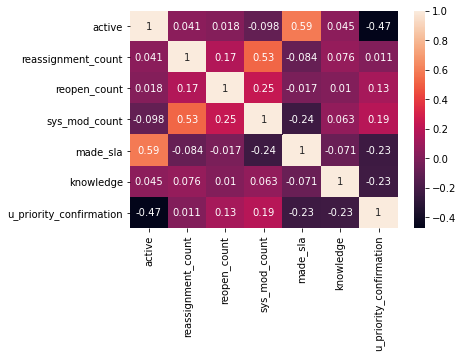

In [108]:
df = pd.DataFrame(df)

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [83]:
df.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

Checking for the SLA. 


In [84]:
df['made_sla'].value_counts()

#made_sla: boolean attribute that shows whether the incident missed the SLA or has time still.

True     111738
False      8260
Name: made_sla, dtype: int64

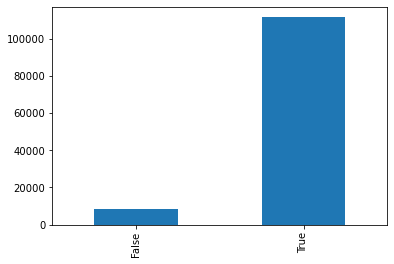

In [85]:
import seaborn as sns #IMPORTING The plotting library
import matplotlib as plt

df.made_sla.value_counts().sort_values().plot(kind = 'bar')

As per the bar plot above, we notice that there are a lot of tickets that have missed SLA and a few tickets are in good shape. 

<h3> How many tickets are closed in a day and how many in more than 3 days. (using IQR) </h3>

In [88]:
from datetime import datetime

df['opened_at']=df['opened_at'].str[:-5]
df['opened_at']

0         29/2/2016 
1         29/2/2016 
2         29/2/2016 
3         29/2/2016 
4         29/2/2016 
             ...    
119993    13/5/2016 
119994    13/5/2016 
119995    13/5/2016 
119996    13/5/2016 
119997    13/5/2016 
Name: opened_at, Length: 119998, dtype: object

In [86]:
from datetime import datetime
#dt=df['resolved_at']
#df['resolved_at'].dtypes
#dfST['timestamp'] = pd.to_datetime(dfST['timestamp'])
#df['resolved_at']=pd.to_datetime(df['resolved_at'])
df['resolved_at']=df['resolved_at'].str[:-5]
df['resolved_at']

0         29/2/2016 
1         29/2/2016 
2         29/2/2016 
3         29/2/2016 
4          1/3/2016 
             ...    
119993    13/5/2016 
119994    13/5/2016 
119995              
119996              
119997    17/5/2016 
Name: resolved_at, Length: 119998, dtype: object

In [93]:
df['resolved_at']=df['resolved_at'].str.strip()

In [94]:
df['opened_at']=df['opened_at'].str.strip()

In [96]:
#creating a new column with the name age having the age of the respective ticket.
#opened_at - resolved_at
#we also have closed date but that doesnot give us the accurate results as the tickets will be closed after a while after reolving.
df['age']=df['resolved_at'].astype(int)-df['opened_at'].astype(int)

ValueError: invalid literal for int() with base 10: '29/2/2016'

<h2> Goal with ML </h2> 
    1. How many tickets can engineers close in a day? <br>
    2. Avergae amount of time an engineer takes to fix the issue. <br>
   